In [1]:
!pip install qulacs
from qulacs import QuantumState,QuantumCircuit, Observable, PauliOperator
from qulacs.gate import X,Z,RX,RY,RZ,CNOT,merge,DenseMatrix,add
from qulacs.state import inner_product
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# 量子ビットの数
nqubits = 4
# ダイナミクスをシミュレーションする時間
t = 10
# トロッター分解の分割数
M = 1000
# 時間の刻み幅
delta = t/M

## 横磁場の強さ
h = 1000

## 初期状態(nquibitsに合わせて変更)
state = QuantumState(nqubits)
initial_states = [0b0000, 0b1101, 0b1010]

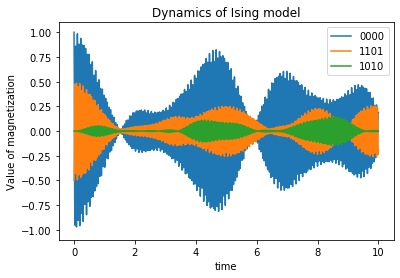

In [3]:
## 全磁化に対応するオブザーバブルを準備しておく
magnetization_obs = Observable(nqubits)
for i in range(nqubits):
     magnetization_obs.add_operator(PauliOperator("Z "+str(i), 1.0/nqubits))

## 時間と磁化を記録するリスト
x = [i*delta for i in range(M+1)]
ylist = []

# トロッター分解の1回分、
# e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} * e^{i X_1*delta}*...*e^{i X_n*delta} を量子ゲートに変換
circuit_trotter_transIsing = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RZ_gate((i+1)%nqubits,-2*delta)
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RX_gate(i, -2*delta*h)

for i in range(len(initial_states)):
    y = []
    state.set_computational_basis(initial_states[i])
    
    #t=0の時の全磁化のみ先に計算
    y.append( magnetization_obs.get_expectation_value(state) )

    #t=0以降の全磁化を計算
    for i in range(M):
        # delta=t/Mだけ時間発展
        circuit_trotter_transIsing.update_quantum_state(state)
        # 磁化を計算して記録
        y.append(magnetization_obs.get_expectation_value(state))
    ylist.append(y)

#グラフの描画
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of Ising model")
plt.ylim(-1.1, 1.1)
for i in range(len(initial_states)):
    plt.plot(x, ylist[i], "-",label=bin(initial_states[i])[2:].ljust(nqubits, '0'))
plt.legend()
plt.show()

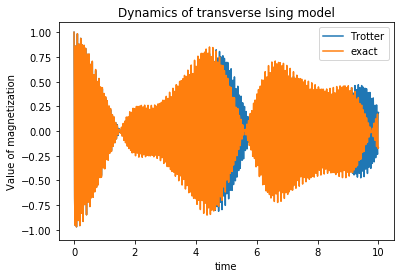

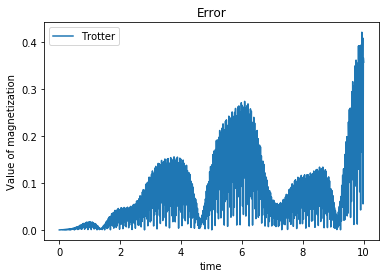

In [4]:
## 初期状態
state_trotter = QuantumState(nqubits)
state_trotter.set_computational_basis(initial_states[0])
state_exact = QuantumState(nqubits)
state_exact.set_computational_basis(initial_states[0])

# トロッター分解の1回分、
# e^{iZ_1Z_2*delta}*e^{iZ_2Z_3*delta}*...e^{iZ_nZ_1*delta} * e^{i X_1*delta}*...*e^{i X_n*delta} を量子ゲートに変換
circuit_trotter_transIsing = QuantumCircuit(nqubits)
for i in range(nqubits):
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RZ_gate((i+1)%nqubits,-2*delta) ## RZ(a)=exp(i*a/2*Z)に注意
    circuit_trotter_transIsing.add_CNOT_gate(i,(i+1)%(nqubits))
    circuit_trotter_transIsing.add_RX_gate(i, -2*delta*h) ## RX(a)=exp(i*a/2*X)に注意

# e^{-iHt}を直接対角化する。Hの行列表現を得るために、gateを生成してそのmatrixを取得する
zz_matrix = -np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]]) ## Z_i*Z_{i+1}の行列表示
hx_matrix = -h*np.array( [ [0,1], [1,0] ] )
zz = DenseMatrix([0,1], zz_matrix) ## 0~1間の相互作用
hx = DenseMatrix(0, hx_matrix) ## 0サイトへの横磁場
## qulacs.gate.addを用いて、1以降のサイトの相互作用と横磁場を足していく
for i in range(1, nqubits):
    zz = add(zz, DenseMatrix([i,(i+1)%nqubits], zz_matrix))
    hx = add(hx, DenseMatrix(i, hx_matrix) )
## 最終的なハミルトニアン
ham = add(zz, hx)
matrix = ham.get_matrix() #行列の取得
eigenvalue, P = np.linalg.eigh(np.array(matrix)) #取得した行列の固有値、固有ベクトルを取得
## e^{-i*H*delta}を行列として作る
e_iHdelta = np.diag(np.exp(-1.0j*eigenvalue*delta))
e_iHdelta = np.dot(P, np.dot(e_iHdelta, P.T))
## 回路に変換
circuit_exact_transIsing = QuantumCircuit(nqubits)
circuit_exact_transIsing.add_dense_matrix_gate( np.arange(nqubits), e_iHdelta)


## 時間と磁化を記録するリスト
x = [i*delta for i in range(M+1)]
y_trotter = []
y_exact = []
#t=0の時の全磁化のみ先に計算
y_trotter.append( magnetization_obs.get_expectation_value(state_trotter) )
y_exact.append( magnetization_obs.get_expectation_value(state_exact) )

#t=0以降の全磁化を計算
for i in range(M):
    # delta=t/Mだけ時間発展
    circuit_trotter_transIsing.update_quantum_state(state_trotter)
    circuit_exact_transIsing.update_quantum_state(state_exact)
    # 磁化を計算して記録
    y_trotter.append( magnetization_obs.get_expectation_value(state_trotter) )
    y_exact.append( magnetization_obs.get_expectation_value(state_exact) )

#グラフの描画
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Dynamics of transverse Ising model")
plt.plot(x, y_trotter, "-", label="Trotter")
plt.plot(x, y_exact, "-", label="exact")
plt.ylim(-1.1, 1.1)
plt.legend()
plt.show()

#エラーの描画
plt.xlabel("time")
plt.ylabel("Value of magnetization")
plt.title("Error")
plt.plot(x, np.abs(np.array(y_trotter) - np.array(y_exact)), "-", label="Trotter")
plt.legend()
plt.show()